# CSE 156:  NLP UCSD, Programming Assignment 4
## Text Decoding From GPT-2 using Beam Search (40 points)
### <font color='blue'> Due: Dec 2, 2024 </font>

###### IMPORTANT: After copying this notebook to your Google Drive, paste a link to it below. To get a publicly-accessible link, click the *Share* button at the top right, then click "Get shareable link" and copy the link.
#### <font color="red">Link: paste your link here:  </font>


https://colab.research.google.com/drive/1PlrxxmZC_IUUiS09h5X-X6YlQtCaSRaP?usp=sharing

---
**Notes:**

Make sure to save the notebook as you go along.

Submission instructions are located at the bottom of the notebook.

# Part 0: Setup

## Adding a hardware accelerator
Go to the menu and add a GPU as follows:

`Edit > Notebook Settings > Hardware accelerator > (GPU)`

Run the following cell to confirm that the GPU is detected.

In [ ]:
import torch

# Confirm that the GPU is detected
assert torch.cuda.is_available()

# Get the GPU device name.
device_name = torch.cuda.get_device_name()
n_gpu = torch.cuda.device_count()
print(f"Found device: {device_name}, n_gpu: {n_gpu}")

Found device: Tesla T4, n_gpu: 1


## Installing Hugging Face's Transformers and Additional Libraries
We will use Hugging Face's Transformers (https://github.com/huggingface/transformers).

Run the following cell to install Hugging Face's Transformers library and some other useful tools.

In [ ]:
pip install -q sentence-transformers==2.2.2 transformers==4.17.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 29.9 MB/s eta 0:00:00


# Part 1. Beam Search
We are going to explore decoding from a pretrained GPT-2 model using beam search. Run the below cell to set up some beam search utilities.

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)

# Beam Search

def init_beam_search(model, input_ids, num_beams):
    assert len(input_ids.shape) == 2
    beam_scores = torch.zeros(num_beams, dtype=torch.float32, device=model.device)
    beam_scores[1:] = -1e9 # Break ties in first round.
    new_input_ids = input_ids.repeat_interleave(num_beams, dim=0).to(model.device)
    return new_input_ids, beam_scores


def run_beam_search_(model, tokenizer, input_text, num_beams=5, num_decode_steps=10, score_processors=[], to_cpu=True):

    input_ids = tokenizer.encode(input_text, return_tensors='pt')

    input_ids, beam_scores = init_beam_search(model, input_ids, num_beams)

    token_scores = beam_scores.clone().view(num_beams, 1)

    model_kwargs = {}
    for i in range(num_decode_steps):
        model_inputs = model.prepare_inputs_for_generation(input_ids, **model_kwargs)
        outputs = model(**model_inputs, return_dict=True)
        next_token_logits = outputs.logits[:, -1, :]
        vocab_size = next_token_logits.shape[-1]
        this_token_scores = torch.log_softmax(next_token_logits, -1)

        # Process token scores.
        processed_token_scores = this_token_scores
        for processor in score_processors:
            processed_token_scores = processor(input_ids, processed_token_scores)

        # Update beam scores.
        next_token_scores = processed_token_scores + beam_scores.unsqueeze(-1)

        # Reshape for beam-search.
        next_token_scores = next_token_scores.view(num_beams * vocab_size)

        # Find top-scoring beams.
        next_token_scores, next_tokens = torch.topk(
            next_token_scores, num_beams, dim=0, largest=True, sorted=True
        )

        # Transform tokens since we reshaped earlier.
        next_indices = torch.div(next_tokens, vocab_size, rounding_mode="floor") # This is equivalent to `next_tokens // vocab_size`
        next_tokens = next_tokens % vocab_size

        # Update tokens.
        input_ids = torch.cat([input_ids[next_indices, :], next_tokens.unsqueeze(-1)], dim=-1)

        # Update beam scores.
        beam_scores = next_token_scores

        # Update token scores.

        # UNCOMMENT: To use original scores instead.
        # token_scores = torch.cat([token_scores[next_indices, :], this_token_scores[next_indices, next_tokens].unsqueeze(-1)], dim=-1)
        token_scores = torch.cat([token_scores[next_indices, :], processed_token_scores[next_indices, next_tokens].unsqueeze(-1)], dim=-1)

        # Update hidden state.
        model_kwargs = model._update_model_kwargs_for_generation(outputs, model_kwargs, is_encoder_decoder=False)
        model_kwargs["past"] = model._reorder_cache(model_kwargs["past"], next_indices)

    def transfer(x):
      return x.cpu() if to_cpu else x

    return {
        "output_ids": transfer(input_ids),
        "beam_scores": transfer(beam_scores),
        "token_scores": transfer(token_scores)
    }


def run_beam_search(*args, **kwargs):
    with torch.inference_mode():
        return run_beam_search_(*args, **kwargs)


# Add support for colored printing and plotting.

from rich import print as rich_print

import numpy as np

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm

RICH_x = np.linspace(0.0, 1.0, 50)
RICH_rgb = (matplotlib.colormaps.get_cmap(plt.get_cmap('RdYlBu'))(RICH_x)[:, :3] * 255).astype(np.int32)[range(5, 45, 5)]


def print_with_probs(words, probs, prefix=None):
  def fmt(x, p, is_first=False):
    ix = int(p * RICH_rgb.shape[0])
    r, g, b = RICH_rgb[ix]
    if is_first:
      return f'[bold rgb(0,0,0) on rgb({r},{g},{b})]{x}'
    else:
      return f'[bold rgb(0,0,0) on rgb({r},{g},{b})] {x}'
  output = []
  if prefix is not None:
    output.append(prefix)
  for i, (x, p) in enumerate(zip(words, probs)):
    output.append(fmt(x, p, is_first=i == 0))
  rich_print(''.join(output))

# DEMO

# Show range of colors.

for i in range(RICH_rgb.shape[0]):
  r, g, b = RICH_rgb[i]
  rich_print(f'[bold rgb(0,0,0) on rgb({r},{g},{b})]hello world rgb({r},{g},{b})')

# Example with words and probabilities.

words = ['the', 'brown', 'fox']
probs = [0.14, 0.83, 0.5]
print_with_probs(words, probs)

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:1439: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(resolved_archive_file, map

hello world rgb(215,49,39)

hello world rgb(244,111,68)

hello world rgb(253,176,99)

hello world rgb(254,226,147)

hello world rgb(251,253,196)

hello world rgb(217,239,246)

hello world rgb(163,210,229)

hello world rgb(108,164,204)

the brown fox

## Question 1.1 (5 points)

Run the cell below. It produces a sequence of tokens using beam search and the provided prefix.

In [ ]:
num_beams = 5
num_decode_steps = 10
input_text = 'The brown fox jumps'

beam_output = run_beam_search(model, tokenizer, input_text, num_beams=num_beams, num_decode_steps=num_decode_steps)
for i, tokens in enumerate(beam_output['output_ids']):
    score = beam_output['beam_scores'][i]
    print(i, round(score.item() / tokens.shape[-1], 3), tokenizer.decode(tokens, skip_special_tokens=True))


0 -1.106 The brown fox jumps out of the fox's mouth, and the fox
1 -1.168 The brown fox jumps out of the fox's cage, and the fox
2 -1.182 The brown fox jumps out of the fox's mouth and starts to run
3 -1.192 The brown fox jumps out of the fox's mouth and begins to lick
4 -1.199 The brown fox jumps out of the fox's mouth and begins to bite


To get you more acquainted with the code, let's do a simple exercise first. Write your own code in the cell below to generate 3 tokens with a beam size of 4, and then print out the **third most probable** output sequence found during the search. Use the same prefix as above.

In [ ]:
input_text = 'The brown fox jumps'

# WRITE YOUR CODE HERE!
num_beams = 4
num_decode_steps = 3

beam_output = run_beam_search(model, tokenizer, input_text, num_beams=num_beams, num_decode_steps=num_decode_steps)
token = tokenizer.decode(beam_output['output_ids'][2], skip_special_tokens=True)
print(token)


The brown fox jumps up and down


## Question 1.2 (5 points)

Run the cell below to visualize the probabilities the model assigns for each generated word when using beam search with beam size 1 (i.e., greedy decoding).

Visualizeation with plot:


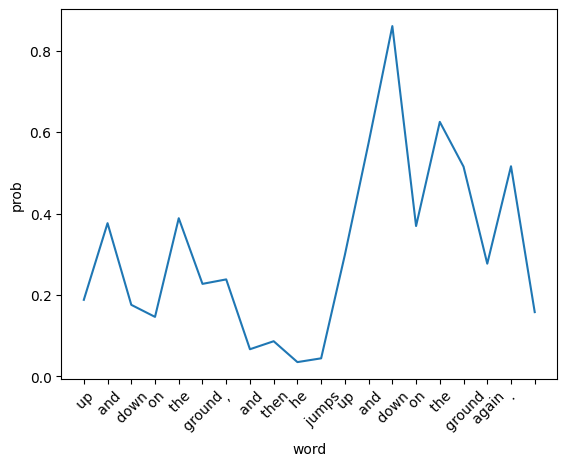

Visualization with colored text (red for lower probability, and blue for higher):


The  brown  fox  jumps up  and  down  on  the  ground ,  and  then  he  jumps  up  and  down  on  the  ground  
again . 

In [ ]:
input_text = 'The brown fox jumps'
beam_output = run_beam_search(model, tokenizer, input_text, num_beams=1, num_decode_steps=20)
probs = beam_output['token_scores'][0, 1:].exp()
output_subwords = [tokenizer.decode(tok, skip_special_tokens=True) for tok in beam_output['output_ids'][0]]

print('Visualizeation with plot:')

fig, ax = plt.subplots()
plt.plot(range(len(probs)), probs)
ax.set_xticks(range(len(probs)))
ax.set_xticklabels(output_subwords[-len(probs):], rotation = 45)
plt.xlabel('word')
plt.ylabel('prob')
plt.show()

print('Visualization with colored text (red for lower probability, and blue for higher):')

print_with_probs(output_subwords[-len(probs):], probs, ' '.join(output_subwords[:-len(probs)]))

Why does the model assign higher probability to tokens generated later than to tokens generated earlier?

#### <font color="red">Answer: </font>

The model tries to predict the next word. as the sequence gets longer the model's knowledge of the context increases and it therefore becomes more certain of the next word.




Run the cell below to visualize the word probabilities when using different beam sizes.

Visualization with plot:


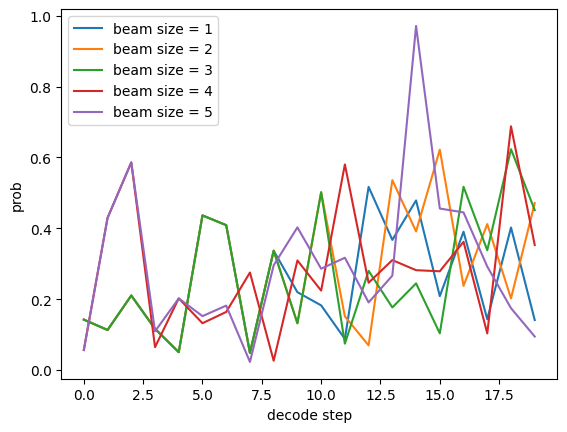

Model predictions:
1 -0.9706197796445905 Once upon a time, in a barn near a farm house, a young boy was playing with a stick. He was playing with a stick, and the boy was
2 -0.9286185177889738 Once upon a time, in a barn near a farm house, a young boy was playing with a stick. The boy was playing with a stick, and the boy
3 -0.9597569667931759 Once upon a time, in a barn near a farm house, a young boy was playing with a stick. The boy, who had been playing with a stick,
4 -0.9205132108746152 Once upon a time, in a barn near a farm house, there was a young girl who had been brought up by her mother. She had been brought up by
5 -0.9058780670166016 Once upon a time, in a barn near a farm house, there was a man who had been living in the house for a long time. He was a man


In [ ]:
input_text = 'Once upon a time, in a barn near a farm house,'
num_decode_steps = 20
model.cuda()

beam_size_list = [1, 2, 3, 4, 5]
output_list = []
probs_list = []
for bm in beam_size_list:
  beam_output = run_beam_search(model, tokenizer, input_text, num_beams=bm, num_decode_steps=num_decode_steps)
  output_list.append(beam_output)
  probs = beam_output['token_scores'][0, 1:].exp()
  probs_list.append((bm, probs))

print('Visualization with plot:')
fig, ax = plt.subplots()
for bm, probs in probs_list:
  plt.plot(range(len(probs)), probs, label=f'beam size = {bm}')
plt.xlabel('decode step')
plt.ylabel('prob')
plt.legend(loc='best')
plt.show()

print('Model predictions:')
for bm, beam_output in zip(beam_size_list, output_list):
  tokens = beam_output['output_ids'][0]
  print(bm, beam_output['beam_scores'][0].item() / tokens.shape[-1], tokenizer.decode(tokens, skip_special_tokens=True))

## Question 1.3 (10 points)

Beam search often results in repetition in the predicted tokens. In the following cell we pass a score processor called `WordBlock` to `run_beam_search`. At each time step, it reduces the probability for any previously seen word so that it is not generated again.

Run the cell to see how the output of beam search changes with and without using `WordBlock`.

In [ ]:
import collections

class WordBlock:
    def __call__(self, input_ids, scores):
        for batch_idx in range(input_ids.shape[0]):
            for x in input_ids[batch_idx].tolist():
                scores[batch_idx, x] = -1e9
        return scores

input_text = 'Once upon a time, in a barn near a farm house,'
num_beams = 1

print('Beam Search')
beam_output = run_beam_search(model, tokenizer, input_text, num_beams=num_beams, num_decode_steps=40, score_processors=[])
print(tokenizer.decode(beam_output['output_ids'][0], skip_special_tokens=True))

print('Beam Search w/ Word Block')
beam_output = run_beam_search(model, tokenizer, input_text, num_beams=num_beams, num_decode_steps=40, score_processors=[WordBlock()])
print(tokenizer.decode(beam_output['output_ids'][0], skip_special_tokens=True))


Beam Search
Once upon a time, in a barn near a farm house, a young boy was playing with a stick. He was playing with a stick, and the boy was playing with a stick. The boy was playing with a stick, and the boy was playing with a
Beam Search w/ Word Block
Once upon a time, in a barn near a farm house, the young girl was playing with her father's dog. She had been told that she would be given to him by his wife and he could take care of it for herself if needed; but when they


Is `WordBlock` a practical way to prevent repetition in beam search? What (if anything) could go wrong when using `WordBlock`?

#### <font color="red">Answer </font>

WordBlock reduces repetition as it decreases the probability for previously seen words. This makes the text more straightforward and less likely to have repetitions, which can make it appear more like human-written.

One drawback with this method is that words need to be and should be reused sometimes. "The" and "a" are two good examples of words that should be reused, this way of reducing repetition in a text may prevent natural repetition of important keywords like the ones above.

penalizing previously seen words may also force the model to choose less likely words that may decrease the grammatical flow, or the factual contents of the text.


## Question 1.4 (20 points)

Use the previous `WordBlock` example to write a new score processor called `BeamBlock`. Instead of uni-grams, your implementation should prevent tri-grams from appearing more than once in the sequence.

Note: This technique is called "beam blocking" and is described [here](https://arxiv.org/pdf/1705.04304.pdf) (section 2.5). Also, for this assignment you do not need to re-normalize your output distribution after masking values, although typically re-normalization is done.

Write your code in the indicated section in the below cell.

In [ ]:
import collections

class BeamBlock:
    def __call__(self, input_ids, scores):
        for batch_idx in range(input_ids.shape[0]):
            token_sequence = input_ids[batch_idx].tolist()

            if len(token_sequence) >= 2:
                seen_trigrams = set(
                    (token_sequence[i], token_sequence[i+1], token_sequence[i+2])
                    for i in range(len(token_sequence) - 2)
                )

                for i in range(len(token_sequence) - 2):
                    trigram_prefix = (token_sequence[i], token_sequence[i + 1])
                    for word_id in range(scores.shape[1]):
                        if (trigram_prefix[0], trigram_prefix[1], word_id) in seen_trigrams:
                            scores[batch_idx, word_id] = -1e9
        return scores

input_text = 'Once upon a time, in a barn near a farm house,'
num_beams = 1

print('Beam Search')
beam_output = run_beam_search(model, tokenizer, input_text, num_beams=num_beams, num_decode_steps=40, score_processors=[])
print(tokenizer.decode(beam_output['output_ids'][0], skip_special_tokens=True))

print('Beam Search w/ Beam Block')
beam_output = run_beam_search(model, tokenizer, input_text, num_beams=num_beams, num_decode_steps=40, score_processors=[BeamBlock()])
print(tokenizer.decode(beam_output['output_ids'][0], skip_special_tokens=True))


Beam Search
Once upon a time, in a barn near a farm house, a young boy was playing with a stick. He was playing with a stick, and the boy was playing with a stick. The boy was playing with a stick, and the boy was playing with a
Beam Search w/ Beam Block
Once upon a time, in a barn near a farm house, the young girl was playing with her father's dog. She had been told that she would be given to him by his wife and he could take care of it for herself if needed; but when they




# <font color="blue"> Submission Instructions</font>
---------------------------

1. Click the Save button at the top of the Jupyter Notebook.
2. Select Cell -> All Output -> Clear. This will clear all the outputs from all cells (but will keep the content of all cells).
2. Select Cell -> Run All. This will run all the cells in order, and will take several minutes.
3. Once you've rerun everything, convert the notebook to PDF, you can use tools such as [nbconvert](https://nbconvert.readthedocs.io/en/latest/usage.html), which requires first downloading the  ipynb  to your local machine, and then running "nbconvert" . (If you have trouble using nbconvert, you can also save the webpage as pdf. <font color='blue'> Make sure all your solutions  are displayed in the pdf</font>, it's okay if the provided codes get cut off because lines are not wrapped in code cells).
4. Look at the PDF file and make sure all your solutions are there, displayed correctly. The PDF is the only thing your graders will see!
5. Submit your PDF on Gradescope,

#### <font color="blue"> Acknowledgements</font>
This assignment is based on an assignment developed by Mohit Iyyer